# **Text Classification**

In this notebook, I will be working with the `20 NewsGroup` dataset which is available through `sklearn`. This dataset contains approximately 18,000 newsgroup posts across 20 different categories/topics.

I use various methods of feature extraction and engineering, as well as several different classification algorithms in order to develop the best performing classifier.

Preprocessing and normalization will proceed in the typical fashion, however, I also consider what additional information should be stripped from each document in order to prevent data leakage. Finally, certain documents which are empty will be removed from the corpus as an additional corpus cleaning step.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

%matplotlib inline

## **1) Setting up the corpus: 20 NewsGroups**

Here I set the `remove` parameter to strip all documents of `headers`, `footers`, and `quotes`. Why sort of information is typically contained in these sections, and why should they be removed before training our text classification model?


Headers, footers, and quotes, may contain unnecessary numbers or punctuation (like page numbers). They will mess up the analysis if they are kept in. I break down the words to their simplest form.

In [ ]:
data = fetch_20newsgroups(subset = 'all', shuffle = True,
                         remove = ('headers', 'footers', 'quotes'))
data_labels_map = dict(enumerate(data.target_names))

# We need to remove hthe header footers and quotes, because they might indicate the catagory of article leading to data leakage.

> #### **A) Build a dataframe to view the corpus containing the article text, target label value, and the target label:**

In [ ]:
corpus, target_labels, target_names = (data.data, data.target,
                                       [data_labels_map[label] for label in data. target])

data_df = pd.DataFrame({'Article': corpus, 'Target Label': target_labels, "target name": target_names})
print(data_df.shape)
data_df.head(10)

(18846, 3)


,Article,Target Label,target name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc


> #### **B) Preprocessing & Normalization**
> Apart from the steps we have been covering in the semester so far regarding cleaning text specifically, what are some other steps to ensure data quality that are not text specific (e.g., what should you check for in any dataset?)

The source you are getting your data from. Is is high quality data?

In [ ]:
# find the number of documents that are completely blank (i.e, contain only blank spaces)
total_nulls = data_df[data_df.Article.str.strip() == ''].shape[0]                              # find the number of documents that are completely blank (i.e, contain only blank spaces)
print("Empty documents:", total_nulls)


Empty documents: 515


In [ ]:
# drop rows where Article is completely blank
data_df = data_df[~(data_df.Article.str.strip() == '')]                                        # drop rows where Article is completely blank
data_df.shape

(18331, 3)

In [ ]:
# check for duplicated rows
duplicate = data_df[data_df.duplicated()]                                                      # check for duplicated rows
print("Duplicate Rows :", len(duplicate))

Duplicate Rows : 47


In [ ]:
# drop duplicated rows
data_df = data_df.drop_duplicates()                                                            # drop duplicated rows
data_df.shape

(18284, 3)

> #### **Normalize the corpus**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from pprint import pprint
import numpy as np
import re
from bs4 import BeautifulSoup

import spacy
nlp = spacy.load('en_core_web_sm')                                                                                            # dependencies

import unicodedata

!pip install contractions
import contractions

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]                                                                         # html parsing
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def tokenize_text(text):                                                                                                      # text tokenization
    sentences = nltk.sent_tokenize(text)
    word_tokens = [nltk.word_tokenize(sentence) for sentence in sentences]
    return word_tokens

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')                            # accent removal
    return text

def expand_contractions(text):                                                                                                # expand contractions
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word))
        expanded_text = ' '.join(expanded_words)
    return expanded_text

def remove_special_characters(text, remove_digits=False):                                                                     # special character removal
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):                                                                                                     # stemmer
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)                                                                                                          # lemmatizer
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False, stopwords=stopword_list):                                                     # stopword removal
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,                                                 # define normalize corpus function
                     accented_char_removal=True, text_lower_case=True,
                     text_lemmatization=True, special_char_removal=True,
                     stopword_removal=True, remove_digits=True):

    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)

        normalized_corpus.append(doc)

    return normalized_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 15.1 MB/s 
     |████████████████████████████████| 106 kB 66.4 MB/s 


In [ ]:
# apply to corpus

In [ ]:
!pip install xlsxwriter
df = data_df.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)                        # this is going to help us write our cleaned dataframe to excel, deal with unicode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 12.5 MB/s 


In [ ]:
# export cleaned corpus dataframe to excel, to save the cleaned version

> #### **Read in Cleaned Excel file**

In [ ]:
df = pd.read_excel("/content/Cleaned_news20.xlsx")
df.head()

,Target Label,Target Name,Article,Clean Article
0,10,rec.sport.hockey,\n\nI am sure some bashers of Pens fans are pr...,I sure basher pen fan pretty confused lack kin...
1,3,comp.sys.ibm.pc.hardware,My brother is in the market for a high-perform...,brother market high performance video card sup...
2,17,talk.politics.mideast,\n\n\n\n\tFinally you said what you dream abou...,finally say dream mediterranean new area great...
3,3,comp.sys.ibm.pc.hardware,\nThink!\n\nIt's the SCSI card doing the DMA t...,think scsi card dma transfer disk scsi card dm...
4,4,comp.sys.mac.hardware,1) I have an old Jasmine drive which I cann...,I old jasmine drive I use new system understan...


> #### **Do one more check to make sure there are no blank documents**

In [ ]:
# replace blank entries with nans
df = df.replace(r'^(\s?)+$',np.nan, regex = True)

# pull up df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18284 entries, 0 to 18283
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Target Label   18284 non-null  int64 
 1   Target Name    18284 non-null  object
 2   Article        18284 non-null  object
 3   Clean Article  18261 non-null  object
dtypes: int64(1), object(3)
memory usage: 571.5+ KB


**Let's drop those nulls out.**

In [ ]:
# drop nas
df = df.dropna().reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18261 entries, 0 to 18260
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Target Label   18261 non-null  int64 
 1   Target Name    18261 non-null  object
 2   Article        18261 non-null  object
 3   Clean Article  18261 non-null  object
dtypes: int64(1), object(3)
memory usage: 570.8+ KB


## **2) Building Train and Test Sets**

My next step in developing a text classification model is to divide out the data into a training and test set. I use 66% of our data to train, and the remaining third as a test set.

In [ ]:
# produce training and test set corpora and labels
train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names=\
                                                                train_test_split(np.array(df['Clean Article']), np.array(df['Target Label']),
                                                                                 np.array(df['Target Name']), test_size = 0.33, random_state = 42)
train_corpus.shape, test_corpus.shape

((12234,), (6027,))

**Let's examine the distribution of news article categories across the training and test sets**

In [ ]:
# create training dictionary of labels
trd = dict(Counter(train_label_names))

# create test set dictionary of labels
tsd = dict(Counter(test_label_names))

# display as dataframe
(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd], columns = ['Target Label', 'Train Count', 'Test Count']).sort_values(by = ["Train Count", "Test Count"]))

,Target Label,Train Count,Test Count
16,talk.religion.misc,395,210
19,talk.politics.misc,518,238
3,alt.atheism,532,247
1,talk.politics.guns,597,289
11,misc.forsale,603,341
6,talk.politics.mideast,619,299
2,sci.med,621,337
17,rec.autos,630,306
4,comp.sys.ibm.pc.hardware,630,333
14,sci.crypt,632,330


**Are the distributions of each category between the training and the test set roughly as expected given a 66-33 split on the data? Which category has the most observations, which has the least?**

There is roughly the same class distribution of article categories across the training and the test set, hockey has the most articles and misc religion has the least.

## **3) Classification with Bag of Words Features**
> #### **Feature Engineering using Bag of Words Modeling**

In [ ]:
# set parameters of BoW
cv = CountVectorizer(binary = False, min_df = 0.0, max_df = 1.0
                    )
# fit model to training corpus, build BOW features on train articles
cv_train_features = cv.fit_transform(train_corpus)


In [ ]:
# transform test articles to BOW features = cv
cv_test_features = cv.transform(test_corpus)

> #### **Fit Classifiers to BoW Features; Evaluate 5-fold Cross-Validated Accuracy**

**Naive Multinomial Bayes** - runs fast

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb = MultinomialNB(alpha=1)                                                              # set model parameters
mnb.fit(cv_train_features, train_label_names)                                             # fit model to training data features & labels (x,y)

mnb_bow_cv_scores = cross_val_score(mnb, cv_train_features, train_label_names, cv=5)      # run 5-fold cross-validation
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)                                        # compute average cross-validated accuracy

print('CV Accuracy (5-fold):', mnb_bow_cv_scores)                                         # print 5-fold accuracy
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)                                         # print average accuracy

mnb_bow_test_score = mnb.score(cv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', mnb_bow_test_score)                                               # print test set accuracy

CV Accuracy (5-fold): [0.67919902 0.67061708 0.67674704 0.68532897 0.66557645]
Mean CV Accuracy: 0.6754937128280628
Test Accuracy: 0.6943753111000498


**How to calculate the baseline?**

We take the number of articles in the majority class divided by the length of the dataframe.


In [ ]:
# print baseline accuracy calculation
print("Baseline Accuracy = ", (670+304)/len(df))


Baseline Accuracy =  0.05333771425442199


**Logistic Regression** -- took about 3 minutes to run using regular runtime

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# train logistic regression model, print accuracies

# set model parameters
lr = LogisticRegression(penalty = 'l2', max_iter = 100, C = 1, random_state = 42)
# fit model to training data features & labels (x,y)
lr.fit(cv_train_features, train_label_names)

# run 5-fold cross-validation
lr_bow_cv_scores = cross_val_score(lr, cv_train_features, train_label_names, cv = 5)
# compute average cross-validated accuracy
lr_bow_cv_mean_score = np.mean(lr_bow_cv_scores)

# print 5-fold accuracy
print('CV Accuracy (f-fold):', lr_bow_cv_scores)
# print average accuracy
print('Mean CV Accuracy:', lr_bow_cv_mean_score)

lr_bow_test_score = lr.score(cv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', lr_bow_test_score)                                               # print test set accuracy

CV Accuracy (f-fold): [0.70208418 0.66857376 0.69718022 0.67184307 0.66680294]
Mean CV Accuracy: 0.6812968371837826
Test Accuracy: 0.6900613904098225


**Was there a considerable difference in performance, yes or no? Does the difference in performance outweigh the difference in training time?**

Not much better than MNB. Not when it is such a close margin.

**Support Vector Machines**

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
# train linear SVM, print accuracies
# set model parameters
svm = LinearSVC(penalty = 'l2', C = 1, random_state = 42)
# fit model to training data features & labels (x,y)
svm.fit(cv_train_features, train_label_names)

# run 5-fold cross-validation
svm_bow_cv_scores = cross_val_score(svm, cv_train_features, train_label_names, cv = 5)
# compute average cross-validated accuracy
svm_bow_cv_mean_score = np.mean(svm_bow_cv_scores)

# print 5-fold accuracy
print('CV Accuracy (f-fold):', svm_bow_cv_scores)
# print average accuracy
print('Mean CV Accuracy:', svm_bow_cv_mean_score)

svm_bow_test_score = svm.score(cv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', svm_bow_test_score)                                               # print test set accuracy

CV Accuracy (f-fold): [0.6546792  0.64609726 0.66693911 0.6411933  0.64022895]
Mean CV Accuracy: 0.649827562643663
Test Accuracy: 0.6537249045959848


**The SVM trained considerably faster than the logistic regression; how does the accuracy compare?**

In this case is lower, though it does train a lot faster. SVM faster than LR. Trade off between accuracy and run time.

**Random Forest Classifier** - took about 30 seconds to train

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# train random forest classifier, print accuracies
# set model parameters
rfc = RandomForestClassifier(n_estimators = 10, random_state = 42)
# fit model to training data features & labels (x,y)
rfc.fit(cv_train_features, train_label_names)

# run 5-fold cross-validation
rfc_bow_cv_scores = cross_val_score(rfc, cv_train_features, train_label_names, cv = 5)
# compute average cross-validated accuracy
rfc_bow_cv_mean_score = np.mean(rfc_bow_cv_scores)

# print 5-fold accuracy
print('CV Accuracy (f-fold):', rfc_bow_cv_scores)
# print average accuracy
print('Mean CV Accuracy:', rfc_bow_cv_mean_score)

rfc_bow_test_score = rfc.score(cv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', rfc_bow_test_score)                                               # print test set accuracy

CV Accuracy (f-fold): [0.53780139 0.51246424 0.52881079 0.53126277 0.49632052]
Mean CV Accuracy: 0.5213319428298573
Test Accuracy: 0.5314418450306952


**Gradient Boosting Machines** -- Took ~10 minutes to run; do outside of class

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# train gradient boosting machine, print accuracies
# set model parameters
gbc = GradientBoostingClassifier(n_estimators = 10, random_state = 42)
# fit model to training data features & labels (x,y)
gbc.fit(cv_train_features, train_label_names)

# run 5-fold cross-validation
gbc_bow_cv_scores = cross_val_score(mnb, cv_train_features, train_label_names, cv = 5)
# compute average cross-validated accuracy
gbc_bow_cv_mean_score = np.mean(gbc_bow_cv_scores)

# print 5-fold accuracy
print('CV Accuracy (f-fold):', gbc_bow_cv_scores)
# print average accuracy
print('Mean CV Accuracy:', gbc_bow_cv_mean_score)

gbc_bow_test_score = gbc.score(cv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', gbc_bow_test_score)                                               # print test set accuracy

CV Accuracy (f-fold): [0.67919902 0.67061708 0.67674704 0.68532897 0.66557645]
Mean CV Accuracy: 0.6754937128280628
Test Accuracy: 0.5495271279243404


**Which of the models had the best performance in correctly classifying article labels; which had the worst? Let's display the test set accuracies for each model in a table below:**

MNB did the best, and Randrom forest performed the worst



In [ ]:
# produce table of test set accuracies by model type
models = gbc_bow_test_score, rfc_bow_test_score, svm_bow_test_score, lr_bow_test_score, mnb_bow_test_score

pd.DataFrame(data = models,
             index = ["GBC", "RFC", "SVM", "LR", "MNB"],
             columns = ["Test Set Accuracy"])

,Test Set Accuracy
GBC,0.549527
RFC,0.531442
SVM,0.653725
LR,0.690061
MNB,0.694375


## **4) TF-IDF Feature Weights**

Clearly none of the models achieved great performance in classifying the topics/categories of the news articles; but remember, BoW models produce very sparse representations of 0s and 1s best on term frequencies within and amongst documents. Let's construct more representative vectors by weighting words by their term frequency-inverse document frequency and then retrain our models.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# set parameters of Tfidf Vectorizer
tv = TfidfVectorizer(use_idf = True, min_df = 0.0, max_df = 1.0)
# fit to training corpus to produce tfidf weights
tv_train_features = tv.fit_transform(train_corpus)
tv_test_features = tv.transform(test_corpus)

In [ ]:
# transform test articles into features

**Mutlinomial Naive Bayes**

In [ ]:
# train mnb on tf-idf features, print accuracies
# set model parameters
mnb = MultinomialNB(alpha = 1)
# fit model to training data features & labels (x,y)
mnb.fit(tv_train_features, train_label_names)

# run 5-fold cross-validation
mnb_bow_tv_scores = cross_val_score(mnb, tv_train_features, train_label_names, cv = 5)
# compute average cross-validated accuracy
mnb_bow_tv_mean_score = np.mean(mnb_bow_tv_scores)

# print 5-fold accuracy
print('cross validation Accuracy (f-fold):', mnb_bow_tv_scores)
# print average accuracy
print('Mean Cross validation Accuracy:', mnb_bow_tv_mean_score)

mnb_bow_test_score = mnb.score(cv_test_features, test_label_names)                        # calculate test set accuracy
print('Test Accuracy:', mnb_bow_test_score)                                               # print test set accuracy

cross validation Accuracy (f-fold): [0.72456069 0.71148345 0.72496935 0.72496935 0.71136549]
Mean Cross validation Accuracy: 0.7194696661622138
Test Accuracy: 0.696200431392069


**Logistic Regression**

In [ ]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42, n_jobs=-1)                          # set n_jobs to -1 to run all CPUs in parallel
lr.fit(tv_train_features, train_label_names)

lr_tfidf_cv_scores = cross_val_score(lr, tv_train_features, train_label_names, cv=5, n_jobs=-1)
lr_tfidf_cv_mean_score = np.mean(lr_tfidf_cv_scores)

print('CV Accuracy (5-fold):', lr_tfidf_cv_scores)
print('Mean CV Accuracy:', lr_tfidf_cv_mean_score)

lr_tfidf_test_score = lr.score(tv_test_features, test_label_names)
print('Test Accuracy:', lr_tfidf_test_score)

CV Accuracy (5-fold): [0.75112383 0.74008991 0.74826318 0.74744585 0.73916599]
Mean CV Accuracy: 0.7452177495697001
Test Accuracy: 0.7469719595155135


**Support Vector Machines**

In [ ]:
# train SVM, print accuracies
# train linear SVM, print accuracies
# set model parameters
svm = LinearSVC(penalty = 'l2', C = 1, random_state = 42)
# fit model to training data features & labels (x,y)
svm.fit(tv_train_features, train_label_names)

# run 5-fold cross-validation
svm_bow_tv_scores = cross_val_score(svm, cv_train_features, train_label_names, cv = 5)
# compute average cross-validated accuracy
svm_bow_tv_mean_score = np.mean(svm_bow_tv_scores)

# print 5-fold accuracy
print('CV Accuracy (f-fold):', svm_bow_tv_scores)
# print average accuracy
print('Mean CV Accuracy:', svm_bow_tv_mean_score)

svm_tfidf_test_score = svm.score(tv_test_features, test_label_names)
print('Test Accuracy:', svm_tfidf_test_score)

CV Accuracy (f-fold): [0.6546792  0.64609726 0.66693911 0.6411933  0.64022895]
Mean CV Accuracy: 0.649827562643663
Test Accuracy: 0.7638958022233283


**Random Forest Classifier**

In [ ]:
# train rfc, print accuracies
# train random forest classifier, print accuracies
# set model parameters
rfc = RandomForestClassifier(n_estimators = 10, random_state = 42)
# fit model to training data features & labels (x,y)
rfc.fit(tv_train_features, train_label_names)

# run 5-fold cross-validation
rfc_bow_tv_scores = cross_val_score(rfc, cv_train_features, train_label_names, cv = 5)
# compute average cross-validated accuracy
rfc_bow_tv_mean_score = np.mean(rfc_bow_tv_scores)

# print 5-fold accuracy
print('CV Accuracy (f-fold):', rfc_bow_tv_scores)
# print average accuracy
print('Mean CV Accuracy:', rfc_bow_tv_mean_score)

rfc_tfidf_test_score = rfc.score(tv_test_features, test_label_names)
print('Test Accuracy:', rfc_tfidf_test_score)

CV Accuracy (f-fold): [0.53780139 0.51246424 0.52881079 0.53126277 0.49632052]
Mean CV Accuracy: 0.5213319428298573
Test Accuracy: 0.536917205906753


**Gradient Boosting Classifier** -- run outside of class because this guy is real slow to train (took 10 min)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(tv_train_features, train_label_names)

gbc_tfidf_cv_scores = cross_val_score(gbc, tv_train_features, train_label_names, cv=5)
gbc_tfidf_cv_mean_score = np.mean(gbc_tfidf_cv_scores)

print('CV Accuracy (5-fold):', gbc_tfidf_cv_scores)
print('Mean CV Accuracy:', gbc_tfidf_cv_mean_score)

gbc_tfidf_test_score = gbc.score(tv_test_features, test_label_names)
print('Test Accuracy:', gbc_tfidf_test_score)

CV Accuracy (5-fold): [0.56272987 0.53248876 0.55864324 0.56967716 0.54292723]
Mean CV Accuracy: 0.5532932511016042
Test Accuracy: 0.5437199269951883


**Overall, is there an improvement in classifier performance using the TF-IDF feature vectors over the basic bag of words feature vectors?**

Below I look at the model performance again.

In [ ]:
pd.DataFrame([['Naive Bayes', mnb_bow_cv_mean_score, mnb_bow_test_score,
               mnb_bow_tv_mean_score, mnb_bow_test_score],
              ['Logistic Regression', lr_bow_cv_mean_score, lr_bow_test_score,
               lr_tfidf_cv_mean_score, lr_tfidf_test_score],
              ['Linear SVM', svm_bow_cv_mean_score, svm_bow_test_score,
               svm_bow_tv_mean_score, svm_tfidf_test_score],
              ['Random Forest', rfc_bow_cv_mean_score, rfc_bow_test_score,
               rfc_bow_tv_mean_score, rfc_tfidf_test_score],
              ['Gradient Boosted Machines', gbc_bow_cv_mean_score, gbc_bow_test_score,
               gbc_tfidf_cv_mean_score, gbc_tfidf_test_score]],
             columns=['Model', 'CV Score (TF)', 'Test Score (TF)', 'CV Score (TF-IDF)', 'Test Score (TF-IDF)'],
             ).T

,0,1,2,3,4
Model,Naive Bayes,Logistic Regression,Linear SVM,Random Forest,Gradient Boosted Machines
CV Score (TF),0.675494,0.675494,0.649828,0.521332,0.675494
Test Score (TF),0.6962,0.694375,0.653725,0.531442,0.549195
CV Score (TF-IDF),0.71947,0.745218,0.649828,0.521332,0.553293
Test Score (TF-IDF),0.6962,0.746972,0.763896,0.536917,0.54372


**Which model and method of feature engineering produced the highest test set and CV accuracies?**

Linear SVM (TFIDF) performed the best.


## **5) Word Embeddings with GloVe**

Next I use a more modern method and utilize some pretrained GloVe embeddings to represent our documents in vector space, to see if I can further improve document classification accuracy.

In [ ]:
!pip install spacy

try:
  spacy.load('en_core_web_lg')
except:
  !python -m spacy download en_core_web_lg

import spacy
nlp = spacy.load('en_core_web_lg')                                                                      # get spacy installed, imported and load glove embeddings model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.4 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


*Took about 4 minutes to produce word embeddings for training and test set*

In [ ]:
train_nlp = [nlp(item) for item in train_corpus]                                                        # fit glove embeddings model to training set
train_glove_features = np.array([item.vector for item in train_nlp])                                    # assign training features to array

test_nlp = [nlp(item) for item in test_corpus]                                                          # fit glove embeddings model to test set
test_glove_features = np.array([item.vector for item in test_nlp])                                      # assign test geatures to array

In [ ]:
[item for item in train_corpus if isinstance(item, float)]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

**Now let's retrain the Linear SVM (best performing) with the GloVe Embeddings to see if the accuracy improves:**

In [ ]:
# train SVM, print accuracies
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(train_glove_features, train_label_names)

svm_glove_cv_scores = cross_val_score(svm, train_glove_features, train_label_names, cv=5)
svm_glove_cv_mean_score = np.mean(svm_glove_cv_scores)

print('CV Accuracy (5-fold):', svm_glove_cv_scores)
print('Mean CV Accuracy:', svm_glove_cv_mean_score)

svm_glove_test_score = svm.score(test_glove_features, test_label_names)
print('Test Accuracy:', svm_glove_test_score)

CV Accuracy (5-fold): [0.58684103 0.56763384 0.6040049  0.6040049  0.56173344]
Mean CV Accuracy: 0.5848436234934495
Test Accuracy: 0.5591504894640783


**Did accuracy improve using word embeddings? Yes or No? Is this surprising?**

Surprisingly, no. I would have thought using word embeddings improved overall performance, however, that doesn't seem to be the case. Perhaps, this has to do with the dimensionality reduction.

## **6) Model Tuning**

Let's take the best performing model with TF-IDF features and perform some tuning.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))                                                 # set pipeline to use tf-idf features with SVM model
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],                                                       # set parameter value range for grid to search
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)                                            # set parameters of cross-validated grid search
gs_svm = gs_svm.fit(train_corpus, train_label_names)                                                        # fit on training data

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   3.4s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   2.8s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   2.2s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   2.3s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   2.4s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=  11.5s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   8.2s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   8.4s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   8.3s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   7.7s
[CV] END ..............svm__C=0.1, tfidf__ngram_range=(1, 1); total time=   1.9s
[CV] END ..............svm__C=0.1, tfidf__ngram_r

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

**If we want to see the parameters of the best performing models**

In [ ]:
# get parameters of best performing model
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('svm', LinearSVC(C=5, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': LinearSVC(C=5, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__C': 5,
 'svm__class_weight': None,
 'svm__dual': True,
 'svm__fit_intercept': True,
 'svm__intercept_scaling': 1,
 'svm__loss': 'squared_hinge',
 'svm__max_iter'

**How much of a lift was there from grid searching?**

It was a relatively small bump (like two percentage points).

In [3]:
# print accuracy of best performing model
best_svm_test_score = gs_svm.score(test_corpus, test_label_names)
print("Test Accuracy:", best_svm_test_score)

## **7) Model Performance Evaluation**

Finally, I examine some other metrics of classification performance: precision, recall, and f1-score. Remember, accuracy isn't the only metric that matters, and it doesn't tell the whole story. We can examine the precision, recall, and f-1 for each individual class to see which categories were most accurately predicted!

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics

In [ ]:
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels,
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels,
                                           y_pred=predicted_labels,
                                           labels=classes)
    print(report)

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):

    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels,
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm,
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes],
                                                  labels=level_labels),
                            index=pd.MultiIndex(levels=[['Actual:'], classes],
                                                labels=level_labels))
    print(cm_frame)

In [ ]:
# get metrics for svm prdictions on test set
svm_predictions = gs_svm.predict(test_corpus)
unique_classes = list(set(test_label_names))

get_metrics(test_label_names, svm_predictions)

Accuracy: 0.7831
Precision: 0.7812
Recall: 0.7831
F1 Score: 0.7811


In [ ]:
# show classification report by category/topic label

display_classification_report(test_label_names, svm_predictions, classes = unique_classes)

                          precision    recall  f1-score   support

        rec.sport.hockey       0.88      0.93      0.90       304
      talk.politics.guns       0.75      0.76      0.76       293
      talk.politics.misc       0.73      0.70      0.72       252
      rec.sport.baseball       0.87      0.87      0.87       327
            misc.forsale       0.76      0.79      0.78       314
         rec.motorcycles       0.78      0.78      0.78       310
               sci.space       0.85      0.84      0.84       324
               rec.autos       0.74      0.81      0.78       306
comp.sys.ibm.pc.hardware       0.71      0.71      0.71       325
             alt.atheism       0.71      0.62      0.66       266
          comp.windows.x       0.82      0.87      0.85       297
 comp.os.ms-windows.misc       0.74      0.74      0.74       296
           comp.graphics       0.77      0.73      0.75       336
  soc.religion.christian       0.76      0.85      0.80       329
         

**Assume that there's roughly equal cost to false positives or negatives for any given class, but there is an uneven class distribution. What is the most important metric among accuracy, recall, precision, and f1-score?**

f-1 score should be prioritized. (Accuracy can't handed uneven class distribution well, and if the cost of FP and FN are roughly similar, there is no addition benefit of using recall or percision.


**With that in mind, which class did the model best predict, and which did it worst predict?**

f-1 score should be prioritized. Hockey was most accurately caputured in predictions, and misc religious was least accurately captured in prediction by our model.


**Let's produce a confusion matrix to examine where the model was making mistakes...**

In [ ]:
label_data_map = {v:k for k, v in data_labels_map.items()}
label_map_df = pd.DataFrame(list(label_data_map.items()), columns=['Label Name', 'Label Number'])
label_map_df

,Label Name,Label Number
0,alt.atheism,0
1,comp.graphics,1
2,comp.os.ms-windows.misc,2
3,comp.sys.ibm.pc.hardware,3
4,comp.sys.mac.hardware,4
5,comp.windows.x,5
6,misc.forsale,6
7,rec.autos,7
8,rec.motorcycles,8
9,rec.sport.baseball,9


<function matplotlib.pyplot.show(close=None, block=None)>

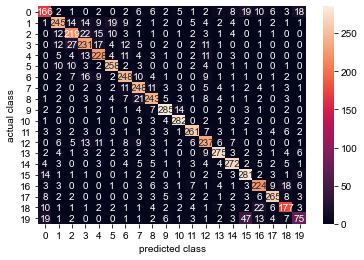

In [ ]:
# generate confusion matrix with seaborn
import seaborn as sns
conf = confusion_matrix(test_label_names, svm_predictions)
sns.heatmap(conf, annot = True, fmt = 'g')
sns.set(rc = {'figure.figsize':(30,30)})
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.show

**Which two categories were most commonly missclassified as one another? Does it make sense that these two categories could be mislabeled as one another, why or why not?**

It was actually about christianity, but the model predicted it was in misc/religion. It makes sense that those two could easily be mislabeled given the similarities in topics.

In [ ]:
# show column labels
label_map_df[label_map_df['Label Number'].isin([15,19])]

,Label Name,Label Number
15,soc.religion.christian,15
19,talk.religion.misc,19


since tfidf vetorizes on frequency on their vocabulary, (and we would expect vocab overlap on these two catagories since the both deal with religion), it isn't surprising that it got mislabeled.